In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, accuracy_score, precision_recall_fscore_support

In [9]:
# MVAE Model Definition
class MVAE(nn.Module):
    def __init__(self, vocab_size, image_embed_size, latent_dim, reg_lambda, fnd_lambda):
        super(MVAE, self).__init__()
        self.latent_dim = latent_dim
        self.reg_lambda = reg_lambda
        self.fnd_lambda = fnd_lambda

        # Encoder layers
        self.txt_embedding = nn.Embedding(vocab_size, 32)
        self.lstm_txt1 = nn.LSTM(32, 32, bidirectional=True, batch_first=True)
        self.lstm_txt2 = nn.LSTM(64, 32, bidirectional=True, batch_first=False)
        self.fc_txt = nn.Linear(64, 32)
        
        self.fc_img1 = nn.Linear(image_embed_size, 1024)
        self.fc_img2 = nn.Linear(1024, 32)

        self.fc_shared = nn.Linear(64, 64)

        self.fc_mean = nn.Linear(64, latent_dim)
        self.fc_log_var = nn.Linear(64, latent_dim)

        # Decoder layers
        self.fc_dec_txt = nn.Linear(latent_dim, 32)
        self.lstm_dec_txt1 = nn.LSTM(32, 32, batch_first=True)
        self.lstm_dec_txt2 = nn.LSTM(32, 32, batch_first=True)
        self.fc_dec_output_txt = nn.Linear(32, vocab_size)

        self.fc_dec_img1 = nn.Linear(latent_dim, 32)
        self.fc_dec_img2 = nn.Linear(32, 1024)
        self.fc_dec_output_img = nn.Linear(1024, 4096)

        # FND layers
        self.fnd_fc1 = nn.Linear(latent_dim, 64)
        self.fnd_fc2 = nn.Linear(64, 32)
        self.fnd_output = nn.Linear(32, 1)

    def encode(self, x_txt, x_img):
        embedded_txt = self.txt_embedding(x_txt)
        lstm_out1, _ = self.lstm_txt1(embedded_txt)
        lstm_out2, _ = self.lstm_txt2(lstm_out1)
        txt_features = self.fc_txt(lstm_out2[:,-1,:])
        #print("Text features shape:", txt_features.shape)  # Should be [128, 32]

        img_features = self.fc_img2(torch.tanh(self.fc_img1(x_img)))
        #print(img_features.shape)

        h = torch.cat((txt_features, img_features), dim=-1)
        h = torch.tanh(self.fc_shared(h))

        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)

        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def decode(self, z):
        dec_txt = self.fc_dec_txt(z)
        dec_txt = dec_txt.unsqueeze(1).repeat(1, 20, 1)  # Repeat for sequence length
        lstm_dec_out1, _ = self.lstm_dec_txt1(dec_txt)
        lstm_dec_out2, _ = self.lstm_dec_txt2(lstm_dec_out1)
        decoded_txt = self.fc_dec_output_txt(lstm_dec_out2)

        dec_img = torch.tanh(self.fc_dec_img1(z))
        decoded_img = torch.sigmoid(self.fc_dec_output_img(self.fc_dec_img2(dec_img)))

        return decoded_txt, decoded_img

    def fnd(self, z):
        h = torch.tanh(self.fnd_fc1(z))
        h = torch.tanh(self.fnd_fc2(h))
        return torch.sigmoid(self.fnd_output(h))

    def forward(self, x_txt, x_img):
        z_mean, z_log_var = self.encode(x_txt, x_img)
        z = self.reparameterize(z_mean, z_log_var)
        decoded_txt, decoded_img = self.decode(z)
        fnd_output = self.fnd(z)
        return decoded_txt, decoded_img, fnd_output, z_mean, z_log_var

In [14]:
# import torch.nn.functional as F
# #import pandas as pd
# # Training Function
# def train(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda, path):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")
#     text = np.load('data/train_text.npy')
#     im = np.load('data/train_image_embed.npy')
#     label = np.load('data/train_label.npy')[:, 1]

#     test_text = np.load('data/test_text.npy')
#     test_im = np.load('data/test_image_embed.npy')
#     test_label = np.load('data/test_label.npy')[:, 1]

#     embed_matrix = np.load('data/embedding_matrix.npy')
#     vocab_size = embed_matrix.shape[0]

#     # Convert to PyTorch tensors
#     train_data = TensorDataset(torch.LongTensor(text), torch.FloatTensor(im), torch.FloatTensor(label))
#     train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

#     model = MVAE(vocab_size, image_embed_size, latent_dim, reg_lambda, fnd_lambda)
#     optimizer = optim.Adam(model.parameters(), lr=1e-5)

#     model.train()
#     loss_data = []
#     for epoch in range(300):
#         for batch in train_loader:
#             x_txt, x_img, y_fnd = batch
#             #print("Shape of x_txt:", x_txt.shape)
#             #print("Shape of x_img:", x_img.shape)

#             optimizer.zero_grad()
#             decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)
            
#             # Normalize x_img embeddings to unit vectors
#             x_img_normalized = F.normalize(x_img, p=2, dim=1)  # L2 normalization
            
            
#             # #print('decode_img: ', decoded_img.shape)
#             # #print('x_img: ', x_img.shape)
#             # # Check the maximum and minimum values
#             # min_value = x_img.min()
#             # max_value = x_img.max()

#             # print(f"Min value in x_img: {min_value.item()}")
#             # print(f"Max value in x_img: {max_value.item()}")
#             # min_value = decoded_img.min()
#             # max_value = decoded_img.max()

#             # print(f"Min value in x_img: {min_value.item()}")
#             # print(f"Max value in x_img: {max_value.item()}")

#             # Loss calculations
#             recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, vocab_size), x_txt.view(-1))
#             recon_img_loss = nn.BCELoss()(decoded_img, x_img_normalized)
#             fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)

#             # KL divergence
#             kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
#             loss = recon_loss + recon_img_loss + fnd_loss + kl_loss
#             loss_data.append(loss)

#             loss.backward()
#             optimizer.step()

#         print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

#     # Save model
#     if not os.path.exists(path):
#         os.makedirs(path)
#     torch.save(model.state_dict(), os.path.join(path, 'mvae.pth'))
#     # Convert the list to a DataFrame
#     # df = pd.DataFrame(loss_data, columns=['Loss'])

#     # # Save the DataFrame to a CSV file
#     # df.to_csv('loss_data.csv', index=False)  # index=False to avoid saving the index column
#     # Open a text file in write mode
#     with open('loss_data.txt', 'w') as f:
#         for loss in loss_data:
#             f.write(f"{loss}\n")  # Write each loss value on a new line

In [12]:
import torch.nn.functional as F


# Training Function
def train(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda, path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    text = np.load('data/train_text.npy')
    im = np.load('data/train_image_embed.npy')
    label = np.load('data/train_label.npy')[:, 1]

    test_text = np.load('data/test_text.npy')
    test_im = np.load('data/test_image_embed.npy')
    test_label = np.load('data/test_label.npy')[:, 1]

    embed_matrix = np.load('data/embedding_matrix.npy')
    vocab_size = embed_matrix.shape[0]

    # Convert to PyTorch tensors and move to the selected device (CUDA or CPU)
    train_data = TensorDataset(
        torch.LongTensor(text).to(device), 
        torch.FloatTensor(im).to(device), 
        torch.FloatTensor(label).to(device)
    )
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

    # Initialize model and move it to the device (CUDA or CPU)
    model = MVAE(vocab_size, image_embed_size, latent_dim, reg_lambda, fnd_lambda).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    model.train()
    loss_data = []
    
    for epoch in range(150):
        for batch in train_loader:
            x_txt, x_img, y_fnd = batch  # Already moved to the device
            
            optimizer.zero_grad()

            # Forward pass
            decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)

            # Normalize x_img embeddings to unit vectors
            x_img_normalized = F.normalize(x_img, p=2, dim=1)  # L2 normalization

            # Loss calculations
            recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, vocab_size), x_txt.view(-1))
            recon_img_loss = nn.BCELoss()(decoded_img, x_img_normalized)
            fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)
            # print(y_fnd.shape)
            # print(fnd_output.shape)

            # KL divergence
            kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

            # Total loss
            loss = recon_loss + recon_img_loss + fnd_loss + kl_loss
            

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        loss_data.append(loss.item())  # Use .item() to extract the scalar value for logging

    # Save model
    if not os.path.exists(path):
        os.makedirs(path)
    #torch.save(model.state_dict(), os.path.join(path, 'mvae.pth'))

    # Save loss data to a text file
    with open('loss_data.txt', 'w') as f:
        for loss in loss_data:
            f.write(f"{loss}\n")  # Write each loss value on a new line
    return loss_data


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# import numpy as np
# import os

# # Training Function
# def train(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda, path):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # Load data
#     text = np.load('data/train_text.npy')
#     im = np.load('data/train_image_embed.npy')
#     label = np.load('data/train_label.npy')[:, 1]

#     # Split the data into training and validation sets
#     text_train, text_val, im_train, im_val, label_train, label_val = train_test_split(
#         text, im, label, test_size=0.2, random_state=42  # Adjust test_size as needed
#     )

#     # Convert to PyTorch tensors and move to the selected device (CUDA or CPU)
#     train_data = TensorDataset(
#         torch.LongTensor(text_train).to(device), 
#         torch.FloatTensor(im_train).to(device), 
#         torch.FloatTensor(label_train).to(device)
#     )
#     train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

#     val_data = TensorDataset(
#         torch.LongTensor(text_val).to(device),
#         torch.FloatTensor(im_val).to(device),
#         torch.FloatTensor(label_val).to(device)
#     )
#     val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

#     # Initialize model and optimizer
#     model = MVAE(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=1e-5)

#     model.train()
#     loss_data = []
#     val_loss_data = []  # To store validation losses

#     for epoch in range(150):
#         # Training phase
#         for batch in train_loader:
#             x_txt, x_img, y_fnd = batch
            
#             optimizer.zero_grad()

#             # Forward pass
#             decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)

#             # Normalize x_img embeddings to unit vectors
#             x_img_normalized = F.normalize(x_img, p=2, dim=1)

#             # Loss calculations
#             recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, sequence_length), x_txt.view(-1))
#             recon_img_loss = nn.BCELoss()(decoded_img, x_img_normalized)
#             fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)

#             # KL divergence
#             kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

#             # Total loss
#             loss = recon_loss + recon_img_loss + fnd_loss + kl_loss
            
#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#         print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}')
#         loss_data.append(loss.item())

#         # Validation phase
#         model.eval()
#         val_loss = 0.0  # Initialize validation loss

#         with torch.no_grad():  # Disable gradient calculation for validation
#             for val_batch in val_loader:
#                 x_txt, x_img, y_fnd = val_batch
                
#                 decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)
                
#                 # Loss calculations for validation
#                 recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, sequence_length), x_txt.view(-1))
#                 recon_img_loss = nn.BCELoss()(decoded_img, F.normalize(x_img, p=2, dim=1))
#                 fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)

#                 kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

#                 # Total validation loss
#                 val_loss += (recon_loss + recon_img_loss + fnd_loss + kl_loss).item()

#         val_loss /= len(val_loader)  # Average validation loss
#         print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')
#         val_loss_data.append(val_loss)

#     # Save model
#     if not os.path.exists(path):
#         os.makedirs(path)
#     # torch.save(model.state_dict(), os.path.join(path, 'mvae.pth'))

#     # Save loss data to a text file
#     with open('loss_data.txt', 'w') as f:
#         for loss in loss_data:
#             f.write(f"{loss}\n")  # Write each training loss value on a new line

#     with open('val_loss_data.txt', 'w') as f:
#         for val_loss in val_loss_data:
#             f.write(f"{val_loss}\n")  # Write each validation loss value on a new line
            
#     return loss_data, val_loss_data


In [4]:
# Testing Function
def test(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda, path):
    test_text = np.load('data/test_text.npy')
    test_im = np.load('data/test_image_embed.npy')
    test_label = np.load('data/test_label.npy')[:, 1]

    embed_matrix = np.load('data/embedding_matrix.npy')
    vocab_size = embed_matrix.shape[0]

    model = MVAE(vocab_size, image_embed_size, latent_dim, reg_lambda, fnd_lambda)
    model.load_state_dict(torch.load(os.path.join(path, 'mvae.pth')))
    model.eval()

    with torch.no_grad():
        x_txt = torch.LongTensor(test_text)
        x_img = torch.FloatTensor(test_im)
        # Normalize x_img embeddings to unit vectors
        x_img_normalized = F.normalize(x_img, p=2, dim=1)  # L2 normalization
        
        # Model prediction
        pred = model(x_txt, x_img_normalized)[-1]  # Last output is the prediction
        
        # Use only the first class's predictions (e.g., index 0)
        first_class_pred = pred[:, 0]  # Get the predictions for the first class
        # Convert to binary (e.g., using a threshold of 0.5)
        binary_pred = (first_class_pred > 0.5).float()

        # Convert PyTorch tensors to NumPy arrays for evaluation
        pred_np = binary_pred.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        test_label_np = test_label  # test_label is already a NumPy array
        
        # Print the shapes of the predictions and true labels for debugging
        print(f"Shape of pred_np: {pred_np.shape}")
        print(f"Shape of test_label_np: {test_label_np.shape}")

        # Flatten the arrays to ensure they're 1D binary arrays
        pred_np = pred_np.flatten()
        test_label_np = test_label_np.flatten()

        accuracy = accuracy_score(test_label, pred_np)
        #precision = precision_score(test_label, pred_np)
        precision, recall, f1, _ = precision_recall_fscore_support(test_label, pred_np, average='binary')

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        return test_label_np, pred_np

In [7]:
if __name__ == '__main__':
   loss_data= train(20, 4096, 64, 0.05, 0.3, 'models/mvae')
   # test(20, 4096, 64, 0.05, 0.3, 'models/mvae')

Using device: cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Training Function
def train(sequence_length, image_embed_size, latent_dim, reg_lambda, fnd_lambda, path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    text = np.load('data/train_text.npy')
    im = np.load('data/train_image_embed.npy')
    label = np.load('data/train_label.npy')[:, 1]

    # Split the data into training and validation sets
    text_train, text_val, im_train, im_val, label_train, label_val = train_test_split(
        text, im, label, test_size=0.2, random_state=42  # Adjust test_size as needed
    )

    # Convert to PyTorch tensors and move to the selected device (CUDA or CPU)
    train_data = TensorDataset(
        torch.LongTensor(text_train).to(device), 
        torch.FloatTensor(im_train).to(device), 
        torch.FloatTensor(label_train).to(device)
    )
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

    val_data = TensorDataset(
        torch.LongTensor(text_val).to(device),
        torch.FloatTensor(im_val).to(device),
        torch.FloatTensor(label_val).to(device)
    )
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

    # Initialize model and optimizer
    model = MVAE(vocab_size, image_embed_size, latent_dim, reg_lambda, fnd_lambda).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    model.train()
    loss_data = []
    val_loss_data = []  # To store validation losses

    for epoch in range(150):
        # Training phase
        for batch in train_loader:
            x_txt, x_img, y_fnd = batch
            
            optimizer.zero_grad()

            # Forward pass
            decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)

            # Normalize x_img embeddings to unit vectors
            x_img_normalized = F.normalize(x_img, p=2, dim=1)

            # Loss calculations
            recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, vocab_size), x_txt.view(-1))
            recon_img_loss = nn.BCELoss()(decoded_img, x_img_normalized)
            fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)

            # KL divergence
            kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

            # Total loss
            loss = recon_loss + recon_img_loss + fnd_loss + kl_loss
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}')
        loss_data.append(loss.item())

        # Validation phase
        model.eval()
        val_loss = 0.0  # Initialize validation loss

        with torch.no_grad():  # Disable gradient calculation for validation
            for val_batch in val_loader:
                x_txt, x_img, y_fnd = val_batch
                
                decoded_txt, decoded_img, fnd_output, z_mean, z_log_var = model(x_txt, x_img)
                
                # Loss calculations for validation
                recon_loss = nn.CrossEntropyLoss()(decoded_txt.view(-1, vocab_size), x_txt.view(-1))
                recon_img_loss = nn.BCELoss()(decoded_img, F.normalize(x_img, p=2, dim=1))
                fnd_loss = nn.BCELoss()(fnd_output.view(-1), y_fnd)

                kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

                # Total validation loss
                val_loss += (recon_loss + recon_img_loss + fnd_loss + kl_loss).item()

        val_loss /= len(val_loader)  # Average validation loss
        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')
        val_loss_data.append(val_loss)

    # Save model
    if not os.path.exists(path):
        os.makedirs(path)
    # torch.save(model.state_dict(), os.path.join(path, 'mvae.pth'))

    # Save loss data to a text file
    with open('loss_data.txt', 'w') as f:
        for loss in loss_data:
            f.write(f"{loss}\n")  # Write each training loss value on a new line

    with open('val_loss_data.txt', 'w') as f:
        for val_loss in val_loss_data:
            f.write(f"{val_loss}\n")  # Write each validation loss value on a new line
            
    return loss_data, val_loss_data


In [13]:
if __name__ == '__main__':
   loss_data, val_loss_data = train(20, 4096, 64, 0.05, 0.3, 'models/mvae')
   # test(20, 4096, 64, 0.05, 0.3, 'models/mvae')

Using device: cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
test_label_np, pred_np=test(20, 4096, 64, 0.05, 0.3, 'models/mvae')

C:\Users\swaru\AppData\Local\Temp\ipykernel_49060\1027288476.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path, 'mvae.p

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [75]:
test_label_np

array([0, 1, 0, ..., 0, 1, 0], dtype=int32)

In [78]:
pred_np.max()

np.float32(0.0)

In [65]:
np.size(loss_data)

31800

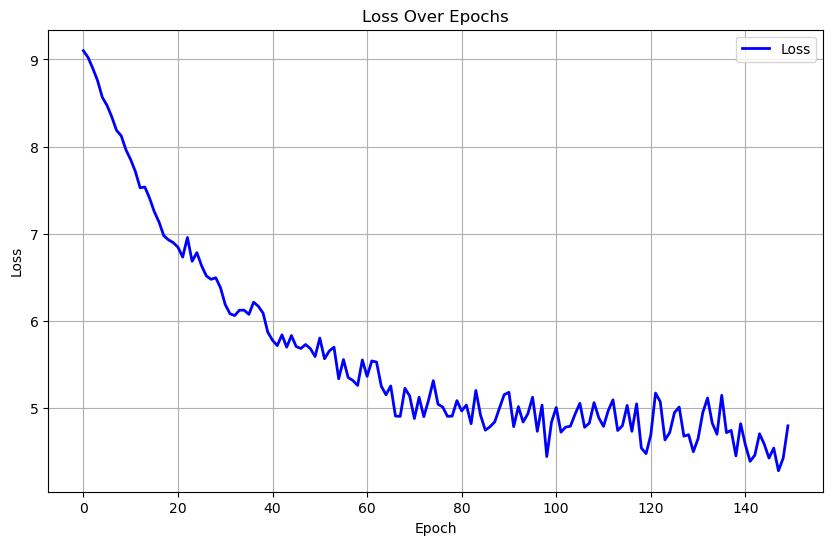

In [69]:
import matplotlib.pyplot as plt

# Step 2: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(loss_data, label='Loss', color='blue', linewidth=2)

# Step 3: Customize the plot
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Step 4: Show the plot
plt.show()
